# Linear Regression with Statsmodels for Movie Revenue - Part 2

## Loading the Data

In [1]:
## Importing custom function for project
%load_ext autoreload
%autoreload 2
import project_functions as pf

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm

In [3]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [4]:
## Checking what data we already in our Data folder using os.listdir
import os
FOLDER = 'Data-Previous/tmdb/'
file_list = sorted(os.listdir(FOLDER))
file_list

['combined_tmdb_api_data.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'final_tmdb_data_2003.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'final_tmdb_data_2005.csv.gz',
 'final_tmdb_data_2006.csv.gz',
 'final_tmdb_data_2007.csv.gz',
 'final_tmdb_data_2008.csv.gz',
 'final_tmdb_data_2009.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'final_tmdb_data_2011.csv.gz',
 'final_tmdb_data_2012.csv.gz',
 'final_tmdb_data_2013.csv.gz',
 'final_tmdb_data_2014.csv.gz',
 'final_tmdb_data_2015.csv.gz',
 'final_tmdb_data_2016.csv.gz',
 'final_tmdb_data_2017.csv.gz',
 'final_tmdb_data_2018.csv.gz',
 'final_tmdb_data_2019.csv.gz',
 'final_tmdb_data_2020.csv.gz',
 'final_tmdb_data_2021.csv.gz']

In [5]:
df = pd.read_csv(FOLDER+'combined_tmdb_api_data.csv.gz',lineterminator='\n')
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,2.491,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.4,21.0,NaN
1,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,1.974,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,4.4,7.0,NaN
2,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",1.341,/yB5wRu4uyXXwZA3PEj8cITu0xt3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
3,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",22.411,/iYypPT4bhqXfq1b6EnmxvRt6b2Y.jpg,"[{'id': 539, 'logo_path': None, 'name': 'Block...","[{'iso_3166_1': 'CN', 'name': 'China'}, {'iso_...",2000-09-29,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1868.0,PG
4,tt0118852,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,"When Harry Levine, an aging, unsuccessful Gree...",4.889,/s6yQFnJohmvdkbeHbx6fFOTpYwR.jpg,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-02,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.9,46.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,/S1kutYyoyuBJKGS0mXxv2fZNbr.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,834443.0,de,Heikos Welt,A son tries to save his mother's eyesight by d...,0.840,/miPUS4bMvooEWUpq8kbC0j7oCie.jpg,"[{'id': 154995, 'logo_path': None, 'name': 'AS...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",2021-09-08,0.0,118.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Heiko's World,0.0,0.0,0.0,NaN
60126,tt9896876,0.0,/hMvRbT6HOqERhh3K8kXbaLz9LlZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,821493.0,en,India Sweets and Spices,A college freshman confronts her parents’ valu...,3.665,/2cUczTzLq1F99Pgiw6BWFsKnD7J.jpg,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-11-19,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Let the aunties talk.,India Sweets and Spices,0.0,6.0,2.0,PG-13
60127,tt9898844,0.0,/q2KFBGyUSzHDhNqXEYv2LqTWVSz.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,870671.0,en,The Hunting,When a mysterious animal attack leaves a mutil...,421.143,/kvhrltQIRp1u84ao9uj52YPaWNY.jpg,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...","[{'iso_3166_1': 'US', 'name': 'United States o...",2022-01-21,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en

## Preprocessing

In [6]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', 'status',
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification
0,tt0113026,0.0,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.4,21.0,NaN
1,tt0113092,0.0,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,For the Cause,4.4,7.0,NaN
2,tt0116391,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.341,[],2000-04-14,0.0,152.0,Gang,0.0,0.0,NaN
3,tt0118694,0.0,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,In the Mood for Love,8.1,1868.0,PG
4,tt0118852,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Chinese Coffee,6.9,46.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",2021-09-08,0.0,118.0,Heiko's World,0.0,0.0,NaN
60126,tt9896876,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",2021-11-19,0.0,101.0,India Sweets and Spices,6.0,2.0,PG-13
60127,tt9898844,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",2022-01-21,0.0,91.0,The Hunting,4.9,20.0,NaN
60128,tt9900940,0.0,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,The Scrapper,6.0,2.0,NaN


### Feature Engineering


- Collection: convert to boolean
- Genres: get just name and OHE
- Cleaning Certification
- Converting release date to year, month, and day.

#### belongs to collection

In [7]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

3738

In [8]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    56392
True      3738
Name: belongs_to_collection, dtype: int64

#### genre

In [9]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [10]:
## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,genres_list
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.4,21.0,NaN,Comedy
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.4,21.0,NaN,Music
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.4,21.0,NaN,Romance
1,tt0113092,0.0,False,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,For the Cause,4.4,7.0,NaN,Science Fiction
2,tt0116391,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.341,[],2000-04-14,0.0,152.0,Gang,0.0,0.0,NaN,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60128,tt9900940,0.0,False,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,The Scrapper,6.0,2.0,NaN,Drama
60128,tt9900940,0.0,False,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,The Scrapper,6.0,2.0,NaN,Thriller
60129,tt9907782,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...",22.184,"[{'id': 26065, 'logo_path': None, 'name': 'Pis...",2021-07-28,4588389.0,111.0,The Cursed,7.0,55.0,R,Horror
60129,tt9907782,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...",22.184,"[{'id': 26065, 'logo_path': None, 'name': 'Pis...",2021-07-28,4588389.0,111.0,The Cursed,7.0,55.0,R,Fantasy


In [11]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    

## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.4,21.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,For the Cause,4.4,7.0,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0116391,0.0,False,0.0,1.341,[],2000-04-14,0.0,152.0,Gang,0.0,0.0,NaN,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,In the Mood for Love,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Chinese Coffee,6.9,46.0,R,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",2021-09-08,0.0,118.0,Heiko's World,0.0,0.0,NaN,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",2021-11-19,0.0,101.0,India Sweets and Spices,6.0,2.0,PG-13,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",2022-01-21,0.0,91.0,The Hunting,4.9,20.0,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,The Scrapper,6.0,2.0,NaN,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False


#### certification

In [12]:
## Checking Certification values
# df['certification'].value_counts(dropna=False)

# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

NaN      45507
R         6098
NR        3270
PG-13     3225
PG        1432
G          442
NC-17      156
Name: certification, dtype: int64

#### Converting year to sep features

In [13]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)
## drop original feature
df = df.drop(columns=['release_date'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",0.0,86.0,The Fantasticks,5.4,21.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,22.0
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",0.0,100.0,For the Cause,4.4,7.0,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,11.0,15.0
2,tt0116391,0.0,False,0.0,1.341,[],0.0,152.0,Gang,0.0,0.0,NaN,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,4.0,14.0
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,In the Mood for Love,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",0.0,99.0,Chinese Coffee,6.9,46.0,R,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",0.0,118.0,Heiko's World,0.0,0.0,NaN,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021.0,9.0,8.0
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",0.0,101.0,India Sweets and Spices,6.0,2.0,PG-13,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021.0,11.0,19.0
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",0.0,91.0,The Hunting,4.9,20.0,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2022.0,1.0,21.0
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",0.0,87.0,The Scrapper,6.0,2.0,NaN,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,2021.0,12.0,7.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   belongs_to_collection  60130 non-null  bool   
 3   budget                 60130 non-null  float64
 4   popularity             60130 non-null  float64
 5   production_companies   60130 non-null  object 
 6   revenue                60130 non-null  float64
 7   runtime                59298 non-null  float64
 8   title                  60130 non-null  object 
 9   vote_average           60130 non-null  float64
 10  vote_count             60130 non-null  float64
 11  certification          14623 non-null  object 
 12  Genre_Comedy           60130 non-null  bool   
 13  Genre_Music            60130 non-null  bool   
 14  Genre_Romance          60130 non-null  bool   
 15  Ge

In [15]:
# df= df.drop(columns='Genre_nan')

## Train Test Split

In [16]:
drop_for_model = ['title','imdb_id','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
0,0.0,False,10000000.0,2.491,0.0,86.0,5.4,21.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,22.0
1,0.0,False,0.0,1.974,0.0,100.0,4.4,7.0,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,11.0,15.0
2,0.0,False,0.0,1.341,0.0,152.0,0.0,0.0,NaN,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,4.0,14.0
3,0.0,False,150000.0,22.411,12854953.0,99.0,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0
4,0.0,False,0.0,4.889,0.0,99.0,6.9,46.0,R,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,0.0,False,0.0,0.840,0.0,118.0,0.0,0.0,NaN,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021.0,9.0,8.0
60126,0.0,False,0.0,3.665,0.0,101.0,6.0,2.0,PG-13,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021.0,11.0,19.0
60127,0.0,False,0.0,421.143,0.0,91.0,4.9,20.0,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2022.0,1.0,21.0
60128,0.0,False,0.0,3.416,0.0,87.0,6.0,2.0,NaN,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,2021.0,12.0,7.0


In [17]:
## Make x and y variables
y = df['revenue'].copy()
X = df.drop(columns=['revenue']).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train.head()

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
9538,0.0,False,0.0,0.600,76.0,0.0,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN
16553,0.0,False,0.0,1.400,79.0,5.8,5.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,8.0,12.0
34106,0.0,False,0.0,2.806,137.0,7.3,24.0,NaN,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2015.0,2.0,10.0
3804,0.0,False,0.0,5.536,95.0,7.4,99.0,NaN,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2003.0,3.0,26.0
37747,0.0,False,0.0,2.818,100.0,4.2,5.0,R,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2016.0,8.0,27.0


In [18]:
X_train.isna().sum()

adult                        0
belongs_to_collection        0
budget                       0
popularity                   0
runtime                    619
vote_average                 0
vote_count                   0
certification            34081
Genre_Comedy                 0
Genre_Music                  0
Genre_Romance                0
Genre_Science Fiction        0
Genre_Drama                  0
Genre_Action                 0
Genre_Crime                  0
Genre_Adventure              0
Genre_Animation              0
Genre_Fantasy                0
Genre_Horror                 0
Genre_Thriller               0
Genre_History                0
Genre_Family                 0
Genre_Mystery                0
Genre_Western                0
Genre_War                    0
Genre_TV Movie               0
Genre_Documentary            0
year                       795
month                      795
day                        795
dtype: int64

In [19]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [20]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [21]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Comedy',
 'Genre_Music',
 'Genre_Romance',
 'Genre_Science Fiction',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Crime',
 'Genre_Adventure',
 'Genre_Animation',
 'Genre_Fantasy',
 'Genre_Horror',
 'Genre_Thriller',
 'Genre_History',
 'Genre_Family',
 'Genre_Mystery',
 'Genre_Western',
 'Genre_War',
 'Genre_TV Movie',
 'Genre_Documentary']

In [22]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)
X_train

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
9538,0.0,0,0.0,0.600,76.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
16553,0.0,0,0.0,1.400,79.0,5.8,5.0,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010.0,8.0,12.0
34106,0.0,0,0.0,2.806,137.0,7.3,24.0,NaN,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015.0,2.0,10.0
3804,0.0,0,0.0,5.536,95.0,7.4,99.0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2003.0,3.0,26.0
37747,0.0,0,0.0,2.818,100.0,4.2,5.0,R,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2016.0,8.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5929,0.0,0,1500000.0,1.779,115.0,6.0,2.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004.0,6.0,9.0
43807,0.0,0,35000000.0,33.694,130.0,6.2,2315.0,R,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,2018.0,1.0,16.0
4220,0.0,0,60000000.0,15.737,119.0,6.2,1451.0,PG-13,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,2003.0,12.0,25.0
6682,0.0,0,0.0,10.566,130.0,6.2,1016.0,PG-13,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2005.0,10.0,7.0


In [23]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((num_pipe, num_cols),
                                       (cat_pipe,cat_cols),remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification'])])

In [24]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-2']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [25]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


## Create the empty list
final_features = [*num_cols,*cat_features,*already_ohe_cols]
len(final_features)

36

In [26]:
preprocessor.transform(X_train).shape

(45097, 36)

In [27]:
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf.head()


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
9538,0.0,0.0,0.600,76.0,0.0,0.0,2013.086926,6.532324,14.456074,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16553,0.0,0.0,1.400,79.0,5.8,5.0,2010.000000,8.000000,12.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34106,0.0,0.0,2.806,137.0,7.3,24.0,2015.000000,2.000000,10.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3804,0.0,0.0,5.536,95.0,7.4,99.0,2003.000000,3.000000,26.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37747,0.0,0.0,2.818,100.0,4.2,5.0,2016.000000,8.000000,27.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                         columns=final_features, index=X_test.index)
X_test_tf.head()

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
19252,0.0,3000000.0,5.738,88.0,5.7,26.0,2011.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40663,0.0,0.0,14.566,140.0,6.5,404.0,2017.0,4.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35595,0.0,350000.0,2.539,90.0,0.0,0.0,2016.0,1.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
979,0.0,0.0,8.717,60.0,4.0,9.0,2000.0,2.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44055,0.0,0.0,1.175,90.0,0.0,0.0,2018.0,10.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 05/19/22 Using sklearn v1.1 fixed get_feature_names_out()

In [29]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((num_pipe, num_cols),
                                       (cat_pipe,cat_cols),
                                       verbose_feature_names_out=False, ## SIMPLIFIES NAMES
                                       remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification'])],
                  verbose_feature_names_out=False)

In [30]:
## fit the col transformer
preprocessor.fit(X_train)
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
X_test_tf = pd.DataFrame( preprocessor.transform(X_test), 
                          columns=preprocessor.get_feature_names_out(),
                          index=X_test.index)
X_train_tf.head()

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
9538,0.0,0.0,0.600,76.0,0.0,0.0,2013.086926,6.532324,14.456074,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16553,0.0,0.0,1.400,79.0,5.8,5.0,2010.000000,8.000000,12.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34106,0.0,0.0,2.806,137.0,7.3,24.0,2015.000000,2.000000,10.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3804,0.0,0.0,5.536,95.0,7.4,99.0,2003.000000,3.000000,26.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37747,0.0,0.0,2.818,100.0,4.2,5.0,2016.000000,8.000000,27.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Adding a Constant for Statsmodels

In [31]:
##import statsmodels correctly
import statsmodels.api as sm

> Tip: make sure that add_constant actually added a new column! You may need to change the parameter `has_constant` to "add"

In [32]:
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
display(X_train_df.head(2),X_test_df.head(2))

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,const
9538,0.0,0.0,0.6,76.0,0.0,0.0,2013.086926,6.532324,14.456074,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16553,0.0,0.0,1.4,79.0,5.8,5.0,2010.000000,8.000000,12.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,const
19252,0.0,3000000.0,5.738,88.0,5.7,26.0,2011.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40663,0.0,0.0,14.566,140.0,6.5,404.0,2017.0,4.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Linear Regression

## Modeling

### Baseline Model

In [33]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3884.
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        22:51:20   Log-Likelihood:            -8.4262e+05
No. Observations:               45097   AIC:                         1.685e+06
Df Residuals:                   45061   BIC:                         1.686e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adult                  2.125e+06    3.8e+06      0.559      0.576   -5.32e+06    9.57e+06
budget                    1.5152      0.014    108.861      0.000       1.488       1.543
popularity             1.365e+05   4607.676     29.618      0.000    1.27e+05    1.46e+05
runtime               -5268.1120   5305.194     -0.993      0.321   -1.57e+04    5130.157
vote_average          -4.993e+05   6.16e+04     -8.103      0.000    -6.2e+05   -3.79e+05
vote_count             2.907e+04    197.891    146.901      0.000    2.87e+04    2.95e+04
year                   1.161e+04   2.67e+04      0.435      0.664   -4.07e+04    6.39e+04
month                 -7.661e+04   4.24e+04     -1.805      0.071    -1.6e+05    6570.407
day                    2851.6453   1.64e+04      0.174      0.862   -2.93e+04     3.5e+04
certification_G       -5.139e+05   6.89e+06     -0.075      0.941    -1.4e+07     1.3e+07
certification_MISSING  1.342e+06   6.76e+06      0.199      0.843   -1.19e+07    1.46e+07
certification_NC-17   -3.772e+06   7.22e+06     -0.523      0.601   -1.79e+07    1.04e+07
certification_NR       5.357e+05   6.79e+06      0.079      0.937   -1.28e+07    1.38e+07
certification_PG        1.44e+06   6.77e+06      0.213      0.832   -1.18e+07    1.47e+07
certification_PG-13   -8.267e+06   6.73e+06     -1.228      0.219   -2.15e+07    4.92e+06
certification_R       -1.311e+07    6.7e+06     -1.956      0.050   -2.62e+07    2.59e+04
belongs_to_collection  1.028e+07   6.61e+05     15.558      0.000    8.99e+06    1.16e+07
Genre_Comedy           1.278e+04   3.65e+05      0.035      0.972   -7.03e+05    7.29e+05
Genre_Music            5.664e+05   1.06e+06      0.535      0.593   -1.51e+06    2.64e+06
Genre_Romance          2.843e+04   4.62e+05      0.061      0.951   -8.78e+05    9.35e+05
Genre_Science Fiction -4.048e+06   6.75e+05     -5.993      0.000   -5.37e+06   -2.72e+06
Genre_Drama           -2.318e+05    3.4e+05     -0.681      0.496   -8.99e+05    4.35e+05
Genre_Action          -1.443e+06   5.08e+05     -2.840      0.005   -2.44e+06   -4.47e+05
Genre_Crime           -2.812e+06   5.97e+05     -4.711      0.000   -3.98e+06   -1.64e+06
Genre_Adventure          3.1e+06   7.51e+05      4.127      0.000    1.63e+06    4.57e+06
Genre_Animation        2.364e+06   9.24e+05      2.559      0.010    5.54e+05    4.17e+06
Genre_Fantasy         -1.083e+06   7.45e+05     -1.453      0.146   -2.54e+06    3.78e+05
Genre_Horror           1.175e+05   4.65e+05      0.253      0.800   -7.93e+05    1.03e+06
Genre_Thriller        -1.303e+06   4.33e+05     -3.010      0.003   -2.15e+06   -4.55e+05
Genre_History         -3.971e+06   1.03e+06     -3.871      0.000   -5.98e+06   -1.96e+06
Genre_Family            -1.1e+06   7.54e+05     -1.460      0.144   -2.58e+06    3.77e+05
Genre_Mystery         -

In [34]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.751
Testing R^2: 0.772


## The Assumptions of Linear Regression

- The 4 Assumptions of a Linear Regression are:
    - Linearity: That the input features have a linear relationship with the target.
    - Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.
    - **Normality: The model's residuals are approximately normally distributed.**
    - **Homoscedasticity: The model residuals have equal variance across all predictions.**


### Diagnosing Model

In [35]:
# def evaluate_ols(result,X_train_df, y_train, figsize=(12,5), show_summary=True):
#     """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
#     """
#     if show_summary==True:
#         try:
#             display(result.summary())
#         except:
#             pass
    
#     ## save residuals from result
#     y_pred = result.predict(X_train_df)
#     resid = y_train - y_pred
    
#     fig, axes = plt.subplots(ncols=2,figsize=figsize)
    
#     ## Normality 
#     sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
#     ## Homoscedasticity
#     ax = axes[1]
#     ax.scatter(y_pred, resid, edgecolor='white',lw=1)
#     ax.axhline(0,zorder=0)
#     ax.set(ylabel='Residuals',xlabel='Predicted Value');
#     plt.tight_layout()
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3884.
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        22:51:20   Log-Likelihood:            -8.4262e+05
No. Observations:               45097   AIC:                         1.685e+06
Df Residuals:                   45061   BIC:                         1.686e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adult                  2.125e+06    3.8e+06      0.559      0.576   -5.32e+06    9.57e+06
budget                    1.5152      0.014    108.861      0.000       1.488       1.543
popularity             1.365e+05   4607.676     29.618      0.000    1.27e+05    1.46e+05
runtime               -5268.1120   5305.194     -0.993      0.321   -1.57e+04    5130.157
vote_average          -4.993e+05   6.16e+04     -8.103      0.000    -6.2e+05   -3.79e+05
vote_count             2.907e+04    197.891    146.901      0.000    2.87e+04    2.95e+04
year                   1.161e+04   2.67e+04      0.435      0.664   -4.07e+04    6.39e+04
month                 -7.661e+04   4.24e+04     -1.805      0.071    -1.6e+05    6570.407
day                    2851.6453   1.64e+04      0.174      0.862   -2.93e+04     3.5e+04
certification_G       -5.139e+05   6.89e+06     -0.075      0.941    -1.4e+07     1.3e+07
certification_MISSING  1.342e+06   6.76e+06      0.199      0.843   -1.19e+07    1.46e+07
certification_NC-17   -3.772e+06   7.22e+06     -0.523      0.601   -1.79e+07    1.04e+07
certification_NR       5.357e+05   6.79e+06      0.079      0.937   -1.28e+07    1.38e+07
certification_PG        1.44e+06   6.77e+06      0.213      0.832   -1.18e+07    1.47e+07
certification_PG-13   -8.267e+06   6.73e+06     -1.228      0.219   -2.15e+07    4.92e+06
certification_R       -1.311e+07    6.7e+06     -1.956      0.050   -2.62e+07    2.59e+04
belongs_to_collection  1.028e+07   6.61e+05     15.558      0.000    8.99e+06    1.16e+07
Genre_Comedy           1.278e+04   3.65e+05      0.035      0.972   -7.03e+05    7.29e+05
Genre_Music            5.664e+05   1.06e+06      0.535      0.593   -1.51e+06    2.64e+06
Genre_Romance          2.843e+04   4.62e+05      0.061      0.951   -8.78e+05    9.35e+05
Genre_Science Fiction -4.048e+06   6.75e+05     -5.993      0.000   -5.37e+06   -2.72e+06
Genre_Drama           -2.318e+05    3.4e+05     -0.681      0.496   -8.99e+05    4.35e+05
Genre_Action          -1.443e+06   5.08e+05     -2.840      0.005   -2.44e+06   -4.47e+05
Genre_Crime           -2.812e+06   5.97e+05     -4.711      0.000   -3.98e+06   -1.64e+06
Genre_Adventure          3.1e+06   7.51e+05      4.127      0.000    1.63e+06    4.57e+06
Genre_Animation        2.364e+06   9.24e+05      2.559      0.010    5.54e+05    4.17e+06
Genre_Fantasy         -1.083e+06   7.45e+05     -1.453      0.146   -2.54e+06    3.78e+05
Genre_Horror           1.175e+05   4.65e+05      0.253      0.800   -7.93e+05    1.03e+06
Genre_Thriller        -1.303e+06   4.33e+05     -3.010      0.003   -2.15e+06   -4.55e+05
Genre_History         -3.971e+06   1.03e+06     -3.871      0.000   -5.98e+06   -1.96e+06
Genre_Family            -1.1e+06   7.54e+05     -1.460      0.144   -2.58e+06    3.77e+05
Genre_Mystery         -

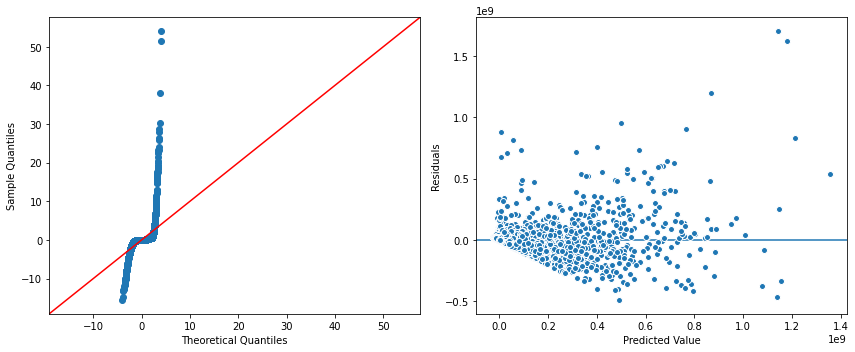

In [36]:
pf.evaluate_ols(result,X_train_df, y_train)

## Improving Our Model:

> "Garbage In = Garbage Out"


- Before we dive into iterating on our model, I realized there were some big issues that I did not account for in the original data. 
    - some movies may not have been released. 
    - We should probably remove movies with 0 budget and revenue.
    

In [37]:
## reload the data
df = pd.read_csv(FOLDER+'combined_tmdb_api_data.csv.gz',lineterminator='\n')
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,2.491,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.4,21.0,NaN
1,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,1.974,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,4.4,7.0,NaN
2,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",1.341,/yB5wRu4uyXXwZA3PEj8cITu0xt3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
3,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",22.411,/iYypPT4bhqXfq1b6EnmxvRt6b2Y.jpg,"[{'id': 539, 'logo_path': None, 'name': 'Block...","[{'iso_3166_1': 'CN', 'name': 'China'}, {'iso_...",2000-09-29,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1868.0,PG
4,tt0118852,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,"When Harry Levine, an aging, unsuccessful Gree...",4.889,/s6yQFnJohmvdkbeHbx6fFOTpYwR.jpg,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-02,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.9,46.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,/S1kutYyoyuBJKGS0mXxv2fZNbr.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,834443.0,de,Heikos Welt,A son tries to save his mother's eyesight by d...,0.840,/miPUS4bMvooEWUpq8kbC0j7oCie.jpg,"[{'id': 154995, 'logo_path': None, 'name': 'AS...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",2021-09-08,0.0,118.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Heiko's World,0.0,0.0,0.0,NaN
60126,tt9896876,0.0,/hMvRbT6HOqERhh3K8kXbaLz9LlZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,821493.0,en,India Sweets and Spices,A college freshman confronts her parents’ valu...,3.665,/2cUczTzLq1F99Pgiw6BWFsKnD7J.jpg,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-11-19,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Let the aunties talk.,India Sweets and Spices,0.0,6.0,2.0,PG-13
60127,tt9898844,0.0,/q2KFBGyUSzHDhNqXEYv2LqTWVSz.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,870671.0,en,The Hunting,When a mysterious animal attack leaves a mutil...,421.143,/kvhrltQIRp1u84ao9uj52YPaWNY.jpg,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...","[{'iso_3166_1': 'US', 'name': 'United States o...",2022-01-21,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en

### Repeating Feature Engineering

In [38]:
## Columns to exclude - Keeping Status and companies
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', #'status','production_companies'
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)

## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()

## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')

## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    


## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])


#### Fixing Certification
## Checking Certification values
df['certification'].value_counts(dropna=False)
# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)


#### Converting year to sep features
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

## drop original feature
df = df.drop(columns=['release_date'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",0.0,86.0,Released,The Fantasticks,5.4,21.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,22.0
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",0.0,100.0,Released,For the Cause,4.4,7.0,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,11.0,15.0
2,tt0116391,0.0,False,0.0,1.341,[],0.0,152.0,Released,Gang,0.0,0.0,NaN,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,4.0,14.0
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,Released,In the Mood for Love,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",0.0,99.0,Released,Chinese Coffee,6.9,46.0,R,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",0.0,118.0,Released,Heiko's World,0.0,0.0,NaN,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021.0,9.0,8.0
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",0.0,101.0,Released,India Sweets and Spices,6.0,2.0,PG-13,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021.0,11.0,19.0
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",0.0,91.0,Released,The Hunting,4.9,20.0,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2022.0,1.0,21.0
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",0.0,87.0,Released,The Scrapper,6.0,2.0,NaN,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,2021.0,12.0,7.0


### New Filtering

- Make sure to only keep:
    1. Status=Released.
    2. Budget >0
    3. Revenue >0

In [39]:
## Check status
df['status'].value_counts()

Released           60097
Post Production       27
In Production          6
Name: status, dtype: int64

In [40]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",0.0,86.0,The Fantasticks,5.4,21.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,22.0
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",0.0,100.0,For the Cause,4.4,7.0,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,11.0,15.0
2,tt0116391,0.0,False,0.0,1.341,[],0.0,152.0,Gang,0.0,0.0,NaN,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,4.0,14.0
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,In the Mood for Love,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",0.0,99.0,Chinese Coffee,6.9,46.0,R,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",0.0,118.0,Heiko's World,0.0,0.0,NaN,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021.0,9.0,8.0
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",0.0,101.0,India Sweets and Spices,6.0,2.0,PG-13,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2021.0,11.0,19.0
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",0.0,91.0,The Hunting,4.9,20.0,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2022.0,1.0,21.0
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",0.0,87.0,The Scrapper,6.0,2.0,NaN,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,2021.0,12.0,7.0


In [41]:
## filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,In the Mood for Love,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0
10,tt0120467,0.0,False,120000.0,5.300,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",14904.0,87.0,Vulgar,5.5,40.0,R,False,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,2002.0,4.0,26.0
12,tt0120630,0.0,True,45000000.0,51.339,"[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...",224834564.0,84.0,Chicken Run,6.7,3997.0,G,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,2000.0,6.0,21.0
15,tt0120753,0.0,False,8000000.0,8.371,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",105983.0,122.0,The Million Dollar Hotel,5.9,247.0,R,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2000.0,2.0,9.0
16,tt0120755,0.0,True,125000000.0,26.731,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",546388105.0,123.0,Mission: Impossible II,6.1,5279.0,PG-13,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,2000.0,5.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60053,tt9639470,0.0,False,43000000.0,157.932,"[{'id': 10146, 'logo_path': '/xnFIOeq5cKw09kCW...",22957625.0,117.0,Last Night in Soho,7.5,1601.0,R,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,2021.0,10.0,21.0
60058,tt9664108,0.0,False,20000000.0,91.077,"[{'id': 148185, 'logo_path': None, 'name': 'No...",4284903.0,108.0,Voyagers,6.1,509.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2021.0,4.0,8.0
60094,tt9784798,0.0,False,26000000.0,16.946,"[{'id': 79426, 'logo_path': '/8aEC7xem9YwHNCDo...",6416063.0,126.0,Judas and the Black Messiah,7.4,1011.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2021.0,2.0,12.0
60106,tt9844322,0.0,False,17516235.0,8.904,"[{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...",19002036.0,120.0,Kaamelott: The First Chapter,6.9,459.0,NaN,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,2021.0,7.0,21.0


### Production Company

In [42]:
df['production_companies']

3        [{'id': 539, 'logo_path': None, 'name': 'Block...
10       [{'id': 102045, 'logo_path': None, 'name': 'Ch...
12       [{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...
15       [{'id': 1490, 'logo_path': None, 'name': 'Kint...
16       [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...
                               ...                        
60053    [{'id': 10146, 'logo_path': '/xnFIOeq5cKw09kCW...
60058    [{'id': 148185, 'logo_path': None, 'name': 'No...
60094    [{'id': 79426, 'logo_path': '/8aEC7xem9YwHNCDo...
60106    [{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...
60107    [{'id': 333, 'logo_path': '/5xUJfzPZ8jWJUDzYtI...
Name: production_companies, Length: 5090, dtype: object

In [43]:
## getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()
idxmax 

143

In [44]:
test = df.loc[idxmax, 'production_companies']
test

"[{'id': 53671, 'logo_path': None, 'name': 'Lantia Cinema & Audiovisivi', 'origin_country': ''}, {'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqmAUkFTrO.png', 'name': 'Fine Line Features', 'origin_country': ''}, {'id': 76, 'logo_path': '/nebkQYtQKhZyHJfh5v0oGpNbPzu.png', 'name': 'Zentropa Entertainments', 'origin_country': 'DK'}, {'id': 119, 'logo_path': '/1di2gITGUZr730AMuMKiCrP90Vl.png', 'name': 'DR', 'origin_country': 'DK'}, {'id': 157, 'logo_path': None, 'name': 'SVT Drama', 'origin_country': ''}, {'id': 201, 'logo_path': '/6UIpEURdjnmcJPwgTDRzVRuwADr.png', 'name': 'ARTE', 'origin_country': 'FR'}, {'id': 321, 'logo_path': '/pfp6VWF3tYfOHHVRHpYe2iGcYrf.png', 'name': 'Memfis Film', 'origin_country': 'SE'}, {'id': 591, 'logo_path': '/q5I5RDwMEiqoNmfaJgd2LraEOJY.png', 'name': 'France 3 Cinéma', 'origin_country': 'FR'}, {'id': 2996, 'logo_path': None, 'name': 'Angel films', 'origin_country': ''}, {'id': 5975, 'logo_path': '/vvjgoKygWWYZvYyidT3RmOCq5If.png', 'name': 'YLE', 'origin_country':

In [45]:
# using regular expressions to extrap just the name
import re
exp= r"\'name\'\:.?\'(\w*.*?)\'"
re.findall(exp, test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [46]:
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies

In [47]:
## test function
get_prod_company_names(test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [48]:
## Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()
prod_companies.value_counts().head(49)

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_17732/4230646071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prod_company'] = df['production_companies'].apply(get_prod_company_names)


Universal Pictures           285
Warner Bros. Pictures        281
Columbia Pictures            234
20th Century Fox             195
Paramount                    178
MISSING                      167
Canal+                       152
New Line Cinema              143
Walt Disney Pictures         135
Relativity Media             123
Lionsgate                    121
DreamWorks Pictures           99
Metro-Goldwyn-Mayer           98
StudioCanal                   96
Village Roadshow Pictures     91
Touchstone Pictures           76
Miramax                       74
Summit Entertainment          72
Dune Entertainment            72
Screen Gems                   69
TSG Entertainment             67
Focus Features                66
Fox Searchlight Pictures      64
Regency Enterprises           62
Sony Pictures                 62
Working Title Films           56
Blumhouse Productions         55
Dimension Films               55
Legendary Pictures            51
Millennium Films              50
The Weinst

In [49]:
prod_companies.nunique()

6367

In [50]:
# df['prod_company'].nunique()

- Common Prod Company Encoding:
    - Keep top 50 most common companies an one hot encode

In [51]:
## saving the 50 most common companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Animation',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Epsilon Motion Pictures',
 'EuropaCorp',
 'Film4 Productions',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'Millennium Films',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Participant',
 'Regency Enterprises',
 'Relativity Media',
 'Revolution Studios',
 'Scott Free Productions',
 'Scott Rudin Productions',
 'Screen Gems',
 'Sony Pictures',
 'Spyglass Entertainment',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney 

In [52]:
## manually ohe top 20 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_17732/197917080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_17732/197917080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_17732/197917080.py:

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_17732/197917080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_17732/197917080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_17732/197917080.py:

In [53]:
## Dropping columns
drop_for_model = ['title','imdb_id','prod_company','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
3,0.0,False,150000.0,22.411,12854953.0,99.0,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,120000.0,5.300,14904.0,87.0,5.5,40.0,R,False,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,2002.0,4.0,26.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,0.0,True,45000000.0,51.339,224834564.0,84.0,6.7,3997.0,G,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,2000.0,6.0,21.0,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
15,0.0,False,8000000.0,8.371,105983.0,122.0,5.9,247.0,R,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2000.0,2.0,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
16,0.0,True,125000000.0,26.731,546388105.0,123.0,6.1,5279.0,PG-13,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,2000.0,5.0,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True

## Checking for Linearity

In [54]:
## concatenating training data into plot_df
plot_df = pd.concat([X_train_df,y_train],axis=1)
plot_df

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,const,revenue
9538,0.0,0.0,0.600,76.0,0.0,0.0,2013.086926,6.532324,14.456074,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16553,0.0,0.0,1.400,79.0,5.8,5.0,2010.000000,8.000000,12.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34106,0.0,0.0,2.806,137.0,7.3,24.0,2015.000000,2.000000,10.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,80551.0
3804,0.0,0.0,5.536,95.0,7.4,99.0,2003.000000,3.000000,26.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37747,0.0,0.0,2.818,100.0,4.2,5.0,2016.000000,8.000000,27.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5929,0.0,1500000.0,1.779,115.0,6.0,2.0,2004.000000,6.000000,9.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
43807,0.0,35000000.0,33.694,130.0,6.2,2315.0,2018.000000,1.000000,16.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,67450815.0
4220,0.0,60000000.0,15.737,119.0,6.2,1451.0,2003.000000,12.000000,25.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,95427515.0
6682,0.0,0.0,10.566,130.0,6.2,1016.0,2005.000000,10.000000,7.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,83073883.0


In [55]:
## save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in plot_df if c.startswith('Genre')]
comp_cols = [c for c in plot_df if c.startswith('ProdComp')]

plot_cols = plot_df.drop(columns=[*genre_cols, *comp_cols]).columns
plot_cols


Index(['adult', 'budget', 'popularity', 'runtime', 'vote_average',
       'vote_count', 'year', 'month', 'day', 'certification_G',
       'certification_MISSING', 'certification_NC-17', 'certification_NR',
       'certification_PG', 'certification_PG-13', 'certification_R',
       'belongs_to_collection', 'const', 'revenue'],
      dtype='object')

In [56]:
len(plot_cols)

19

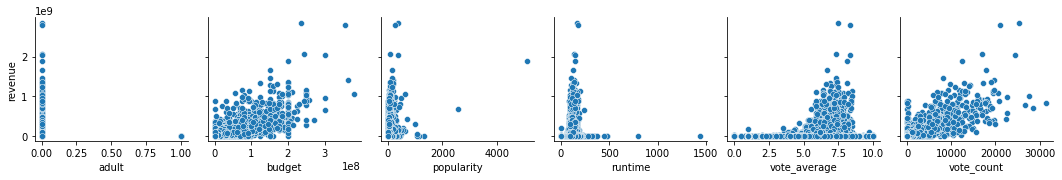

In [57]:
## Plot first 6 features
sns.pairplot(data=plot_df, y_vars='revenue', x_vars=plot_cols[:6])

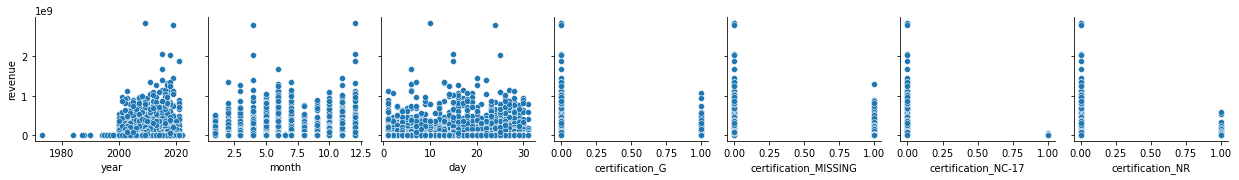

In [58]:
## Plot next 6 features
sns.pairplot(data=plot_df, y_vars='revenue', x_vars=plot_cols[6:13])

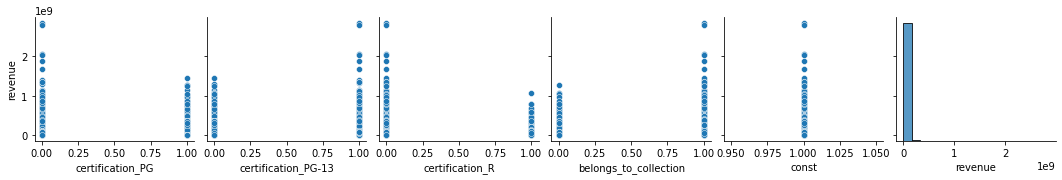

In [59]:
## plot remaining features
sns.pairplot(data=plot_df, y_vars='revenue', x_vars=plot_cols[13:])

- Shouldn't have years before 2000, so drop. 
- Check outliers in popularity, runtime


In [60]:
# remove movies prior to 2000
df = df.loc[ df['year']>=2000]
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
3,0.0,False,150000.0,22.411,12854953.0,99.0,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,120000.0,5.300,14904.0,87.0,5.5,40.0,R,False,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,2002.0,4.0,26.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,0.0,True,45000000.0,51.339,224834564.0,84.0,6.7,3997.0,G,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,2000.0,6.0,21.0,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
15,0.0,False,8000000.0,8.371,105983.0,122.0,5.9,247.0,R,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2000.0,2.0,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
16,0.0,True,125000000.0,26.731,546388105.0,123.0,6.1,5279.0,PG-13,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,2000.0,5.0,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True

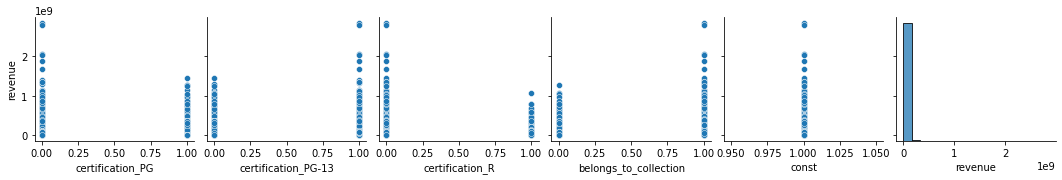

In [61]:
## plot remaining features
sns.pairplot(data=plot_df, y_vars='revenue', x_vars=plot_cols[13:])

> Now need to recreate X and y varaibles

### Functionize ALL of the preprocessing

In [62]:
def get_train_test_split(df_, y_col='revenue',drop_cols=[]):
    
    ## Make copy of input df
    df = df_.copy()
    
    ## filter columns in drop cols (if exist)
    final_drop_cols = []
    [df.drop(columns=c,inplace=True) for c in df.columns if c in drop_cols]
    
    
    ## Make x and y variables
    y = df[y_col].copy()
    X = df.drop(columns=[y_col]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
    

    
    ## make cat selector and using it to save list of column names
    cat_select = make_column_selector(dtype_include='object')
    cat_cols = cat_select(X_train)


    ## make num selector and using it to save list of column names
    num_select = make_column_selector(dtype_include='number')
    num_cols = num_select(X_train)


    ## select manually OHE cols for later
    bool_select = make_column_selector(dtype_include='bool')
    already_ohe_cols = bool_select(X_train)

    ## convert manual ohe to int
    X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
    X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

    ## make pipelines
    cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                            )

    preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')
    
    

    ## fit the col transformer
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


    ## Create the empty list
    final_features = [*cat_features,*num_cols,*already_ohe_cols]

    ## Make df verisons of x data
    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels
    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
    return X_train_df, y_train, X_test_df, y_test


### Model #1

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     150.4
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        22:51:24   Log-Likelihood:                -75282.
No. Observations:                3810   AIC:                         1.507e+05
Df Residuals:                    3727   BIC:                         1.512e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                      -25.1130     30.538     -0.822      0.411     -84.986      34.760
certification_MISSING                  1.9113      0.060     32.066      0.000       1.794       2.028
certification_NC-17                 1.624e+05   1.53e+04     10.590      0.000    1.32e+05    1.92e+05
certification_NR                    2.607e+05   8.63e+04      3.022      0.003    9.16e+04     4.3e+05
certification_PG                   -4.042e+06   1.51e+06     -2.685      0.007   -6.99e+06   -1.09e+06
certification_PG-13                 2.913e+04    690.157     42.203      0.000    2.78e+04    3.05e+04
certification_R                     2.297e+05   2.94e+05      0.781      0.435   -3.47e+05    8.06e+05
adult                              -2.344e+05   4.52e+05     -0.519      0.604   -1.12e+06    6.52e+05
budget                             -3.946e+04   1.78e+05     -0.222      0.825   -3.89e+05     3.1e+05
popularity                         -5.726e+07   7.41e+07     -0.773      0.440   -2.03e+08     8.8e+07
runtime                            -5.183e+07   7.46e+07     -0.695      0.487   -1.98e+08    9.44e+07
vote_average                       -6.831e+07   7.78e+07     -0.879      0.380   -2.21e+08    8.41e+07
vote_count                         -5.445e+07   7.46e+07     -0.730      0.466   -2.01e+08    9.18e+07
year                               -5.016e+07   7.41e+07     -0.677      0.499   -1.95e+08    9.52e+07
month                              -6.329e+07   7.41e+07     -0.854      0.393   -2.09e+08     8.2e+07
day                                -8.084e+07   7.41e+07     -1.092      0.275   -2.26e+08    6.44e+07
belongs_to_collection               5.031e+07   4.22e+06     11.925      0.000     4.2e+07    5.86e+07
Genre_Comedy                        5.802e+06   3.96e+06      1.465      0.143   -1.96e+06    1.36e+07
Genre_Music                         1.389e+07   9.19e+06      1.512      0.131   -4.13e+06    3.19e+07
Genre_Romance                       7.309e+06   4.39e+06      1.666      0.096   -1.29e+06    1.59e+07
Genre_Science Fiction              -3.325e+07   5.72e+06     -5.810      0.000   -4.45e+07    -2.2e+07
Genre_Drama                         1.005e+06   3.94e+06      0.255      0.799   -6.73e+06    8.74e+06
Genre_Action                       -1.124e+07   4.29e+06     -2.618      0.009   -1.97e+07   -2.82e+06
Genre_Crime                        -4.114e+06   4.88e+06     -0.843      0.399   -1.37e+07    5.45e+06
Genre_Adventure                     3.671e+06   5.15e+06      0.713      0.476   -6.42e+06    1.38e+07
Genre_Animation                     1.211e+07   8.69e+06      1.393      0.164   -4.93e+06    2.92e+07
Genre_Fantasy                      -3.085e+06   5.59e+06     -0.552      0.581    -1.4e+07    7.

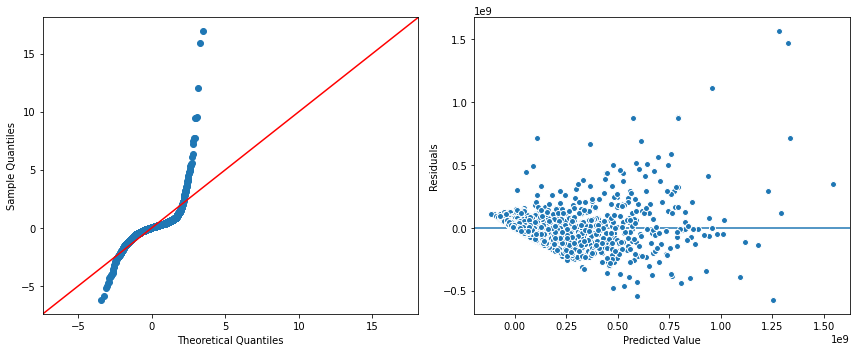

In [63]:
## Use our function to make new x,y vars
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)
X_train_df

## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
pf.evaluate_ols(result, X_train_df, y_train)

> We are definitely violating the assumptions of normal residuals and homoscedasticity.

## Removing Outliers

### Using Z-Score Rule

In [64]:
help(pf.find_outliers_Z)
# from scipy import stats
# def find_outliers(data, verbose=True):
#     outliers = np.abs(stats.zscore(data))>3
    
#     if verbose:
#         print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
#     return outliers

Help on function find_outliers_Z in module project_functions:

find_outliers_Z(data, verbose=True)
    Identifies outliers using Z-score > 3 rule.
    
    Args:
            data (pd.Series): data to check for outliers
            verbose (bool, optional): Print # of outliers in column. Defaults to True.
    
    Returns:
            Boolean Series: pd.Series with True/False for every value



In [65]:
pf.find_outliers_Z(df['runtime'])

- 0 outliers found in runtime using Z-Scores.


3        False
10       False
12       False
15       False
16       False
         ...  
60053    False
60058    False
60094    False
60106    False
60107    False
Name: runtime, Length: 5081, dtype: bool

In [66]:
## save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = ['runtime','popularity','revenue']

outliers = {}

for col in outlier_cols:
    col_outliers = pf.find_outliers_Z(df[col])
    
    outliers[col] = col_outliers

- 0 outliers found in runtime using Z-Scores.
- 34 outliers found in popularity using Z-Scores.
- 128 outliers found in revenue using Z-Scores.


In [67]:
# Make new df_clean copy of df
df_clean = df.copy()

## loop through dictionary to remove outliers
for col, col_outliers in outliers.items():
    df_clean  = df_clean.loc[~col_outliers]

In [68]:
df_clean

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
3,0.0,False,150000.0,22.411,12854953.0,99.0,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,120000.0,5.300,14904.0,87.0,5.5,40.0,R,False,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,2002.0,4.0,26.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,0.0,True,45000000.0,51.339,224834564.0,84.0,6.7,3997.0,G,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,2000.0,6.0,21.0,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
15,0.0,False,8000000.0,8.371,105983.0,122.0,5.9,247.0,R,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2000.0,2.0,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
16,0.0,True,125000000.0,26.731,546388105.0,123.0,6.1,5279.0,PG-13,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,2000.0,5.0,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True

### Model 2: Outliers Removed (Z_scores)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     151.0
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        22:51:24   Log-Likelihood:                -70921.
No. Observations:                3696   AIC:                         1.420e+05
Df Residuals:                    3613   BIC:                         1.425e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                       11.1640      9.836      1.135      0.256      -8.120      30.448
certification_MISSING                  1.3247      0.038     34.854      0.000       1.250       1.399
certification_NC-17                 7.253e+04   3.81e+04      1.901      0.057   -2256.589    1.47e+05
certification_NR                    8.646e+04      5e+04      1.730      0.084   -1.15e+04    1.84e+05
certification_PG                    -6.46e+05   8.69e+05     -0.743      0.457   -2.35e+06    1.06e+06
certification_PG-13                 2.127e+04    492.705     43.168      0.000    2.03e+04    2.22e+04
certification_R                    -1.877e+05   1.71e+05     -1.100      0.271   -5.22e+05    1.47e+05
adult                              -5.001e+04   2.58e+05     -0.194      0.846   -5.56e+05    4.56e+05
budget                              5.184e+04   1.02e+05      0.507      0.612   -1.49e+05    2.52e+05
popularity                          4.964e+07   4.31e+07      1.151      0.250   -3.49e+07    1.34e+08
runtime                             5.001e+07   4.33e+07      1.155      0.248   -3.49e+07    1.35e+08
vote_average                        4.292e+07   4.52e+07      0.949      0.343   -4.57e+07    1.32e+08
vote_count                          4.529e+07   4.33e+07      1.047      0.295   -3.95e+07     1.3e+08
year                                5.564e+07    4.3e+07      1.293      0.196   -2.87e+07     1.4e+08
month                               4.384e+07   4.29e+07      1.021      0.307   -4.03e+07    1.28e+08
day                                 3.011e+07   4.29e+07      0.701      0.483   -5.41e+07    1.14e+08
belongs_to_collection               3.285e+07   2.43e+06     13.532      0.000    2.81e+07    3.76e+07
Genre_Comedy                        4.261e+06   2.27e+06      1.875      0.061   -1.95e+05    8.72e+06
Genre_Music                         1.157e+07   5.34e+06      2.167      0.030     1.1e+06     2.2e+07
Genre_Romance                       4.332e+06   2.53e+06      1.711      0.087   -6.32e+05     9.3e+06
Genre_Science Fiction              -2.268e+07   3.37e+06     -6.721      0.000   -2.93e+07   -1.61e+07
Genre_Drama                        -2.519e+06   2.29e+06     -1.099      0.272   -7.01e+06    1.98e+06
Genre_Action                       -1.068e+06   2.46e+06     -0.435      0.664   -5.88e+06    3.75e+06
Genre_Crime                        -3.204e+06   2.78e+06     -1.153      0.249   -8.65e+06    2.24e+06
Genre_Adventure                    -6.418e+06   2.96e+06     -2.167      0.030   -1.22e+07    -6.1e+05
Genre_Animation                     1.547e+07   5.05e+06      3.066      0.002    5.58e+06    2.54e+07
Genre_Fantasy                      -1.345e+07    3.3e+06     -4.073      0.000   -1.99e+07   -6.

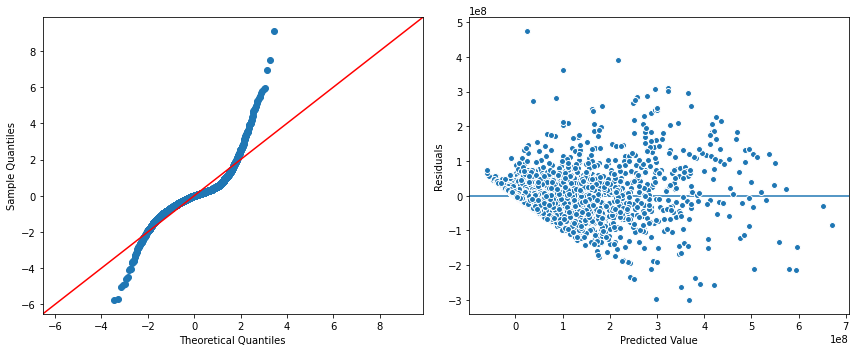

In [69]:
## Use our function to make new x,y vars
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean)


## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
pf.evaluate_ols(result, X_train_df, y_train)

### Removing Outliers - Using IQR Rule

<AxesSubplot:xlabel='revenue'>

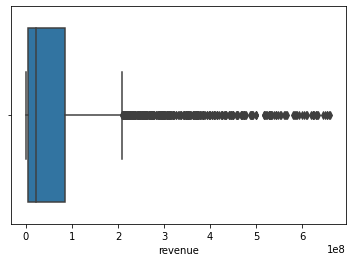

In [70]:
## visualzie outlier-removed target
sns.boxplot(x = y_train)

In [71]:
# def find_outliers_IQR(data, verbose=True):
#     q3 = np.quantile(data,.75)
#     q1 = np.quantile(data,.25)

#     IQR = q3 - q1
#     upper_threshold = q3 + 1.5*IQR
#     lower_threshold = q1 - 1.5*IQR
    
#     outliers = (data<lower_threshold) | (data>upper_threshold)
#     if verbose:
#         print(f"- {outliers.sum()} outliers found in {data.name} using IQR.")
        
#     return outliers

In [72]:
outliers_z = pf.find_outliers_Z(df['revenue'])
outliers_iqr = pf.find_outliers_IQR(df['revenue'])

- 128 outliers found in revenue using Z-Scores.
- 540 outliers found in revenue using IQR.


In [73]:
## Loop to remove outliers from same clumns using new function
outlier_cols = ['runtime','popularity','revenue']

## Empty dict for both types of outliers
## save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = ['runtime','popularity','revenue']

outliers_z = {}
outliers_IQR = {}

for col in outlier_cols:
    col_outliers_z = pf.find_outliers_Z(df[col])
    outliers_z[col] = col_outliers_z
    
    col_outliers_iqr = pf.find_outliers_IQR(df[col])
    outliers_IQR[col] = col_outliers_iqr
    print()
## Use both functions to see the comparison for # of outliers


- 0 outliers found in runtime using Z-Scores.
- 0 outliers found in runtime using IQR.

- 34 outliers found in popularity using Z-Scores.
- 518 outliers found in popularity using IQR.

- 128 outliers found in revenue using Z-Scores.
- 540 outliers found in revenue using IQR.



In [74]:
# # remove_outliers - create df_clean_z
# df_clean_z = df.copy()

# ## loop though outliers_z


In [75]:
# Make new df_clean copy of df
df_clean_iqr = df.copy()

## loop through dictionary to remove outliers
for col, col_outliers in outliers_IQR.items():
    df_clean_iqr  = df_clean_iqr.loc[~col_outliers]
df_clean_iqr

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
3,0.0,False,150000.0,22.411,12854953.0,99.0,8.1,1868.0,PG,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2000.0,9.0,29.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,120000.0,5.300,14904.0,87.0,5.5,40.0,R,False,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,2002.0,4.0,26.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,0.0,True,45000000.0,51.339,224834564.0,84.0,6.7,3997.0,G,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,2000.0,6.0,21.0,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
15,0.0,False,8000000.0,8.371,105983.0,122.0,5.9,247.0,R,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2000.0,2.0,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
18,0.0,False,75000000.0,17.464,36754634.0,94.0,6.6,848.0,PG,False,False,False,True,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,2000.0,6.0,16.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

### Model 3 - IQR Outliers Removed

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     73.49
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        22:51:25   Log-Likelihood:                -60209.
No. Observations:                3229   AIC:                         1.206e+05
Df Residuals:                    3146   BIC:                         1.211e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                       -0.1837      0.061     -2.991      0.003      -0.304      -0.063
certification_MISSING                  0.7385      0.030     24.513      0.000       0.679       0.798
certification_NC-17                 4.996e+05    6.7e+04      7.463      0.000    3.68e+05    6.31e+05
certification_NR                     1.26e+05   3.02e+04      4.176      0.000    6.69e+04    1.85e+05
certification_PG                    4.614e+05    5.1e+05      0.905      0.365   -5.38e+05    1.46e+06
certification_PG-13                 1.201e+04    486.560     24.687      0.000    1.11e+04     1.3e+04
certification_R                    -3.062e+05   1.08e+05     -2.838      0.005   -5.18e+05   -9.47e+04
adult                              -6.514e+04    1.6e+05     -0.408      0.684   -3.78e+05    2.48e+05
budget                             -2.983e+04   6.34e+04     -0.471      0.638   -1.54e+05    9.44e+04
popularity                          7.885e+07   2.73e+07      2.892      0.004    2.54e+07    1.32e+08
runtime                             7.451e+07   2.74e+07      2.721      0.007    2.08e+07    1.28e+08
vote_average                        7.105e+07   2.83e+07      2.515      0.012    1.57e+07    1.26e+08
vote_count                            7.4e+07   2.74e+07      2.704      0.007    2.03e+07    1.28e+08
year                                8.118e+07   2.72e+07      2.990      0.003    2.79e+07    1.34e+08
month                                7.89e+07   2.72e+07      2.904      0.004    2.56e+07    1.32e+08
day                                 6.611e+07   2.71e+07      2.438      0.015    1.29e+07    1.19e+08
belongs_to_collection               1.817e+07   1.62e+06     11.247      0.000     1.5e+07    2.13e+07
Genre_Comedy                        4.559e+06   1.41e+06      3.229      0.001    1.79e+06    7.33e+06
Genre_Music                          3.77e+06   3.11e+06      1.213      0.225   -2.32e+06    9.87e+06
Genre_Romance                       3.137e+06   1.52e+06      2.064      0.039    1.57e+05    6.12e+06
Genre_Science Fiction              -1.613e+07   2.28e+06     -7.089      0.000   -2.06e+07   -1.17e+07
Genre_Drama                        -5.036e+06   1.41e+06     -3.571      0.000    -7.8e+06   -2.27e+06
Genre_Action                       -1.042e+06   1.56e+06     -0.668      0.504    -4.1e+06    2.02e+06
Genre_Crime                         -1.33e+06    1.7e+06     -0.781      0.435   -4.67e+06    2.01e+06
Genre_Adventure                     -3.94e+06   1.97e+06     -1.999      0.046    -7.8e+06    -7.5e+04
Genre_Animation                    -2.745e+06   3.35e+06     -0.820      0.412   -9.31e+06    3.82e+06
Genre_Fantasy                      -8.259e+06   2.17e+06     -3.803      0.000   -1.25e+07      

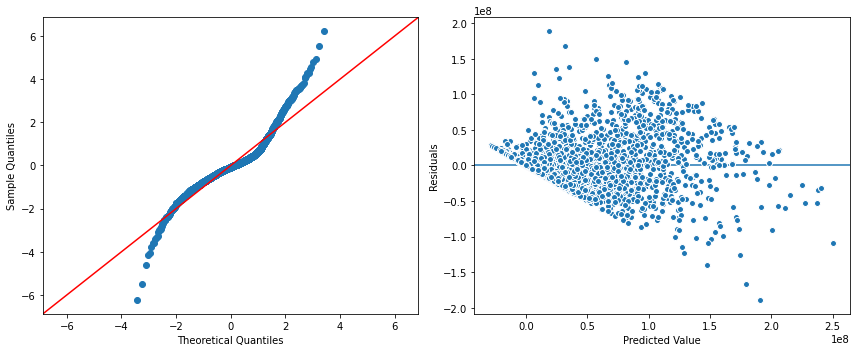

In [76]:
## Use our function to make new x,y vars
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_iqr)
X_train_df

## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
pf.evaluate_ols(result, X_train_df, y_train)

> How are we doing??

In [77]:
## get pvalues from model result
pvalues =result.pvalues
pvalues

certification_G                        2.803842e-03
certification_MISSING                 1.367979e-121
certification_NC-17                    1.089607e-13
certification_NR                       3.052198e-05
certification_PG                       3.652966e-01
                                          ...      
ProdComp_Village Roadshow Pictures     5.414453e-02
ProdComp_Walt Disney Pictures          6.342961e-05
ProdComp_Warner Bros. Pictures         4.690943e-01
ProdComp_Working Title Films           5.110055e-01
const                                  5.733314e-03
Length: 87, dtype: float64

In [78]:
## Check for p-values that are >.05
pvalues[pvalues>.05]

certification_PG                      0.365297
adult                                 0.683530
budget                                0.637822
Genre_Music                           0.225288
Genre_Action                          0.504384
Genre_Crime                           0.434807
Genre_Animation                       0.412285
Genre_Horror                          0.207494
Genre_Thriller                        0.662812
Genre_History                         0.672200
Genre_Family                          0.244324
Genre_Mystery                         0.300616
Genre_Western                         0.088170
Genre_War                             0.387664
Genre_Documentary                     0.518153
ProdComp_BBC Films                    0.991494
ProdComp_Canal+                       0.899679
ProdComp_Ciné+                        0.823543
ProdComp_Dimension Films              0.437845
ProdComp_DreamWorks Animation         0.851426
ProdComp_Epsilon Motion Pictures      0.129670
ProdComp_Film

## Removing features - based on p-values

In [79]:
## Get list of ALL genre columns to see how many are sig
genre_cols

['Genre_Comedy',
 'Genre_Music',
 'Genre_Romance',
 'Genre_Science Fiction',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Crime',
 'Genre_Adventure',
 'Genre_Animation',
 'Genre_Fantasy',
 'Genre_Horror',
 'Genre_Thriller',
 'Genre_History',
 'Genre_Family',
 'Genre_Mystery',
 'Genre_Western',
 'Genre_War',
 'Genre_TV Movie',
 'Genre_Documentary']

In [80]:
## save just genre pvalues
genre_pvals = pvalues[genre_cols]
genre_pvals

Genre_Comedy             1.255056e-03
Genre_Music              2.252884e-01
Genre_Romance            3.908509e-02
Genre_Science Fiction    1.666064e-12
Genre_Drama              3.608560e-04
Genre_Action             5.043838e-01
Genre_Crime              4.348072e-01
Genre_Adventure          4.571915e-02
Genre_Animation          4.122851e-01
Genre_Fantasy            1.457638e-04
Genre_Horror             2.074942e-01
Genre_Thriller           6.628116e-01
Genre_History            6.721996e-01
Genre_Family             2.443240e-01
Genre_Mystery            3.006162e-01
Genre_Western            8.816988e-02
Genre_War                3.876644e-01
Genre_TV Movie           5.723358e-03
Genre_Documentary        5.181534e-01
dtype: float64

In [81]:
# len(comp_pvals>.05)/len(comp_pvals)
print('% of Good P-Values')
(genre_pvals<.05).value_counts(normalize=True)*100

% of Good P-Values


False    63.157895
True     36.842105
dtype: float64

In [82]:
# (genre_pvals>.05) /len(genre_pvals)

In [83]:
# ## calc what % are insig?
# len(genre_pvals>.05)/len(genre_pvals)

In [84]:
comp_cols = [c for c in df_clean_iqr if c.startswith('ProdComp')]


In [85]:
comp_cols

['ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Animation',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Legendary Pictures',
 'ProdComp_Lionsgate',
 'ProdComp_MISSING',
 'ProdComp_Metro-Goldwyn-Mayer',
 'ProdComp_Millennium Films',
 'ProdComp_Miramax',
 'ProdComp_New Line Cinema',
 'ProdComp_New Regency Pictures',
 'ProdComp_Original Film',
 'ProdComp_Paramount',
 'ProdComp_Participant',
 'ProdComp_Regency Enterprises',
 'ProdComp_Relativity Media',
 'ProdComp_Revolution Studios',
 'ProdComp_Scot

In [86]:
## Get list of ALL prod_comp columns to see how many are sig
comp_pvals = pvalues[comp_cols]
comp_pvals

ProdComp_20th Century Fox             1.140870e-04
ProdComp_BBC Films                    9.914940e-01
ProdComp_Blumhouse Productions        5.546390e-04
ProdComp_CJ Entertainment             5.532855e-03
ProdComp_Canal+                       8.996790e-01
ProdComp_Ciné+                        8.235428e-01
ProdComp_Columbia Pictures            7.569057e-06
ProdComp_Dimension Films              4.378450e-01
ProdComp_DreamWorks Animation         8.514255e-01
ProdComp_DreamWorks Pictures          5.233421e-03
ProdComp_Dune Entertainment           4.634798e-03
ProdComp_Epsilon Motion Pictures      1.296704e-01
ProdComp_EuropaCorp                   3.813172e-02
ProdComp_Film4 Productions            2.173503e-01
ProdComp_Focus Features               4.356357e-01
ProdComp_Fox 2000 Pictures            6.689552e-01
ProdComp_Fox Searchlight Pictures     6.929100e-01
ProdComp_France 2 Cinéma              2.648040e-02
ProdComp_France 3 Cinéma              9.466950e-01
ProdComp_Ingenious Media       

In [87]:
# len(comp_pvals>.05)/len(comp_pvals)
print('% of Good P-Values')
(comp_pvals<.05).value_counts(normalize=True)*100

% of Good P-Values


False    64.0
True     36.0
dtype: float64

In [88]:
## save just genre pvalues


> both have <50% bad pvalues. Keep both!

In [89]:
## what pvals are remaining?


### Model 4

In [90]:
df_clean_iqr = df_clean_iqr.drop(columns=[*genre_cols, *comp_cols])
df_clean_iqr

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,year,month,day
3,0.0,False,150000.0,22.411,12854953.0,99.0,8.1,1868.0,PG,2000.0,9.0,29.0
10,0.0,False,120000.0,5.300,14904.0,87.0,5.5,40.0,R,2002.0,4.0,26.0
12,0.0,True,45000000.0,51.339,224834564.0,84.0,6.7,3997.0,G,2000.0,6.0,21.0
15,0.0,False,8000000.0,8.371,105983.0,122.0,5.9,247.0,R,2000.0,2.0,9.0
18,0.0,False,75000000.0,17.464,36754634.0,94.0,6.6,848.0,PG,2000.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59962,0.0,False,15000000.0,33.611,18192220.0,130.0,6.5,1093.0,R,2021.0,7.0,29.0
59998,0.0,False,27500000.0,39.824,19046191.0,137.0,6.4,163.0,PG-13,2021.0,9.0,24.0
60005,0.0,True,11000000.0,16.265,3189418.0,133.0,6.2,333.0,NaN,2021.0,12.0,16.0
60094,0.0,False,26000000.0,16.946,6416063.0,126.0,7.4,1011.0,NaN,2021.0,2.0,12.0


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     342.0
Date:                Sat, 21 May 2022   Prob (F-statistic):               0.00
Time:                        22:51:25   Log-Likelihood:                -60347.
No. Observations:                3229   AIC:                         1.207e+05
Df Residuals:                    3213   BIC:                         1.208e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G               

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env-m1/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


- Figure saved as Images/OLS_best_linear_reg.png


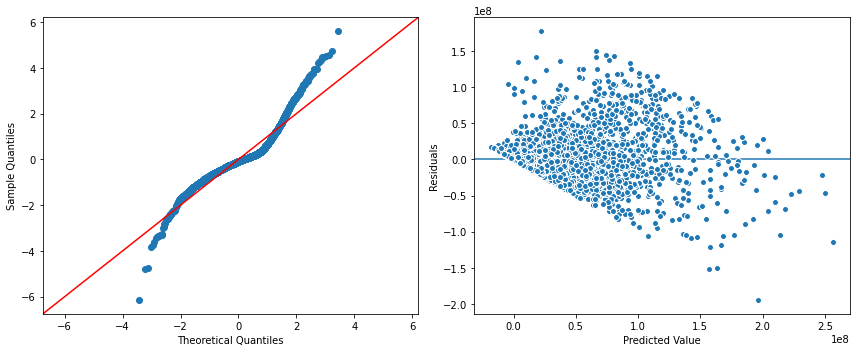

In [91]:
## Use our function to make new x,y vars
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_iqr)

## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
print(result.summary())
fig = pf.evaluate_ols(result, X_train_df, y_train,show_summary=False,
                      return_fig=True)
pf.savefig('Images/OLS_best_linear_reg.png',fig=fig)

## Addressing Multicollinearity

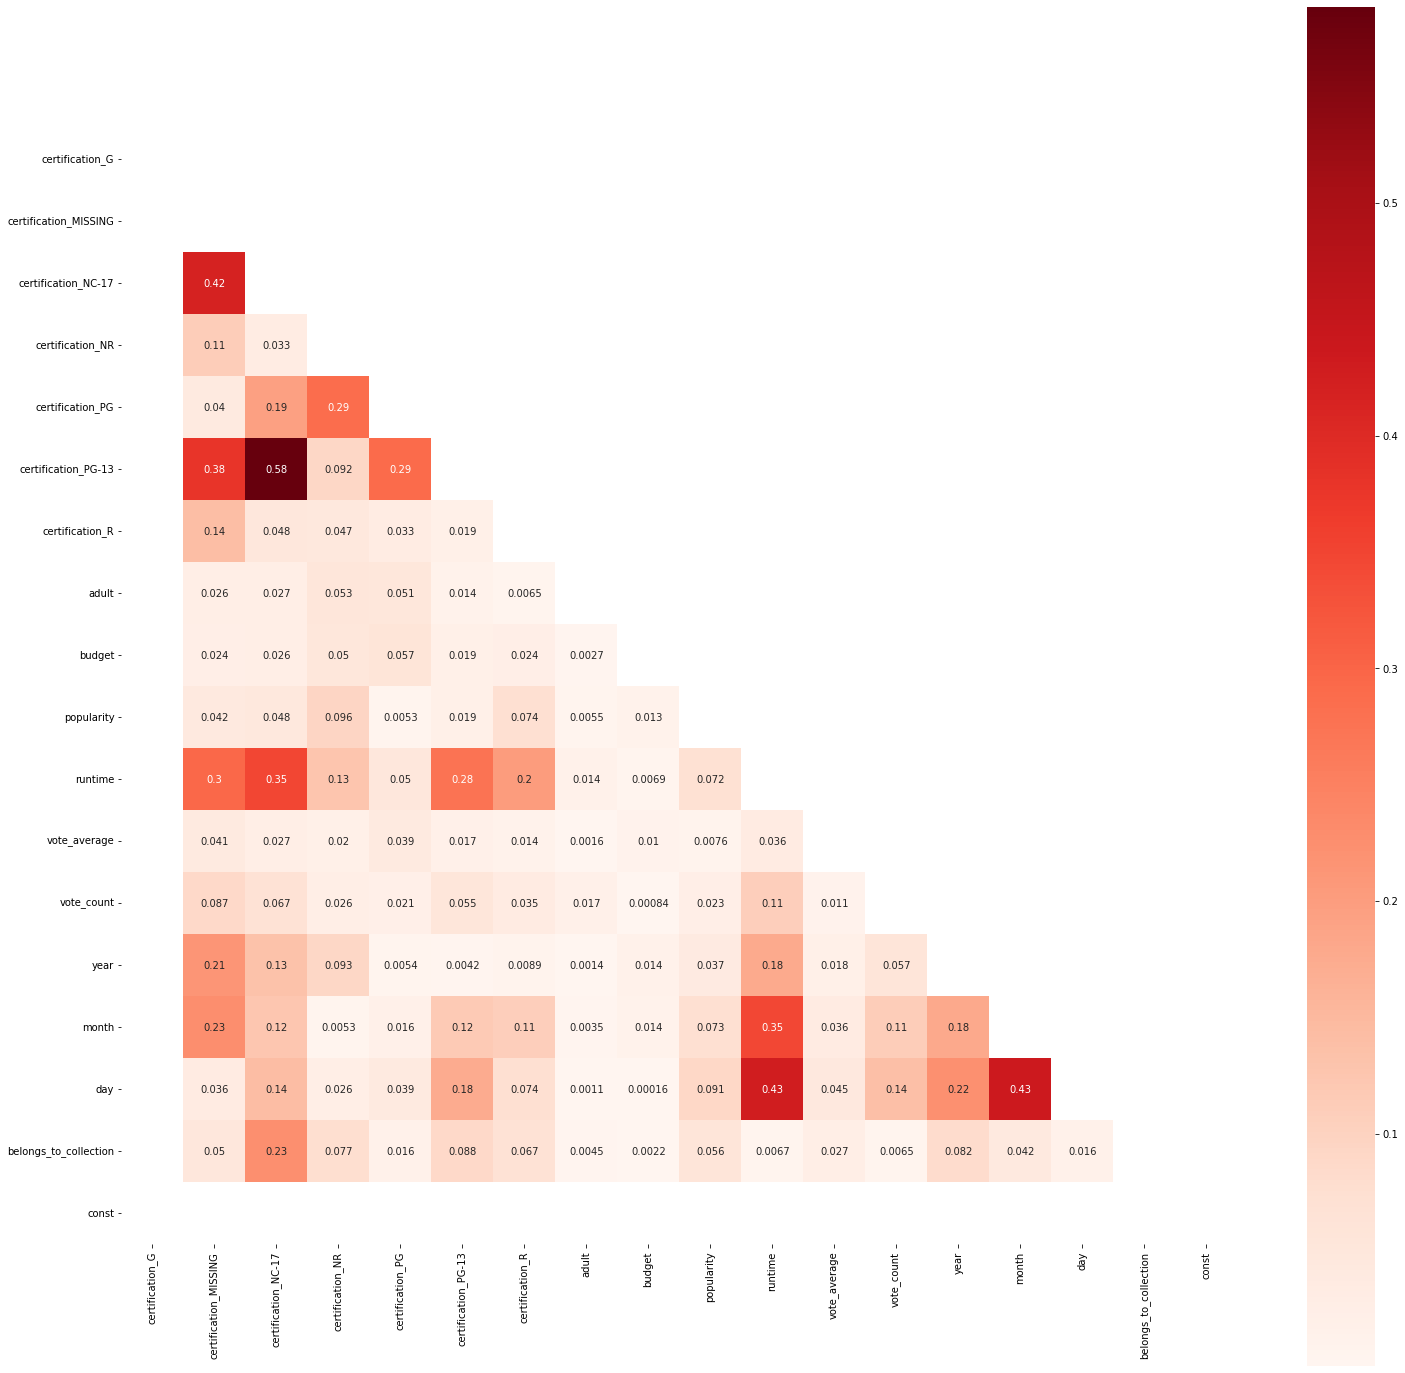

In [92]:
## Calculating the mask to hide the upper-right of the triangle
corr = X_train_df.corr().abs()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(25,25))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

### Variance Inflation Factor

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
# separate just x-data and subtract mean
features = X_train_df -  X_train_df.mean()

features

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,const
1790,0.0,-1.460857e+07,-7.140289,5.678748,-0.317405,-1016.993496,-9.229793,1.173428,-12.211211,-0.015175,-0.254258,-0.003716,-0.034066,-0.083617,0.741096,-0.350263,-0.160111,0.0
16347,0.0,2.839143e+07,0.521711,20.678748,-0.217405,260.006504,-0.229793,3.173428,6.788789,-0.015175,-0.254258,-0.003716,-0.034066,-0.083617,0.741096,-0.350263,-0.160111,0.0
38664,0.0,-2.093857e+07,-8.967289,26.678748,1.282595,-966.993496,5.770207,4.173428,-11.211211,-0.015175,0.745742,-0.003716,-0.034066,-0.083617,-0.258904,-0.350263,0.839889,0.0
22194,0.0,-9.091919e+06,-5.479289,-30.321252,1.582595,-628.993496,1.770207,5.173428,-3.211211,-0.015175,-0.254258,-0.003716,-0.034066,0.916383,-0.258904,-0.350263,-0.160111,0.0
6611,0.0,-1.460857e+07,-5.438289,5.678748,0.782595,44.006504,-5.229793,2.173428,14.788789,-0.015175,-0.254258,-0.003716,-0.034066,-0.083617,-0.258904,0.649737,-0.160111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,0.0,1.839143e+07,-6.437289,-7.321252,-2.617405,-806.993496,-8.229793,1.173428,-6.211211,-0.015175,-0.254258,-0.003716,-0.034066,-0.083617,-0.258904,0.649737,-0.160111,0.0
24990,0.0,1.759143e+07,42.446711,18.678748,0.682595,6955.006504,2.770207,1.173428,-14.211211,-0.015175,-0.254258,-0.003716,-0.034066,-0.083617,-0.258904,0.649737,-0.160111,0.0
12351,0.0,1.391427e+06,12.848711,-10.321252,0.482595,871.006504,-2.229793,-4.826572,-1.211211,-0.015175,-0.254258,-0.003716,-0.034066,-0.083617,0.741096,-0.350263,0.839889,0.0
39517,0.0,1.533914e+08,15.969711,17.678748,0.282595,3783.006504,6.770207,-1.826572,-5.211211,-0.015175,-0.254258,-0.003716,-0.034066,-0.083617,0.741096,-0.350263,-0.160111,0.0


In [94]:
# create a list of VIF scores for each feature in features.
vif_scores = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

# create a new dataframe to hold the VIF scores 
VIF = pd.Series(vif_scores, index=features.columns)
VIF


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env-m1/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env-m1/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


certification_G               NaN
certification_MISSING    1.497753
certification_NC-17      1.880450
certification_NR         1.190444
certification_PG         1.221393
certification_PG-13      1.735366
certification_R          1.109888
adult                    1.007809
budget                   1.006515
popularity                    inf
runtime                       inf
vote_average                  inf
vote_count                    inf
year                          inf
month                         inf
day                           inf
belongs_to_collection    1.091990
const                         NaN
dtype: float64

- Figure saved as Images/OLS_coeffs.png


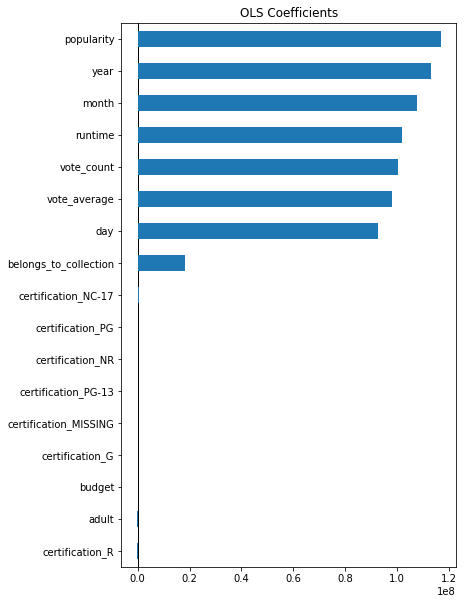

In [95]:
ax = result.params.drop('const').sort_values().tail(25).plot(kind='barh',figsize=(6,10))
ax.axvline(0,color='k',lw=1,zorder=0)
ax.set_title('OLS Coefficients')
pf.savefig('Images/OLS_coeffs.png',ax=ax)

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_17732/3278389331.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');


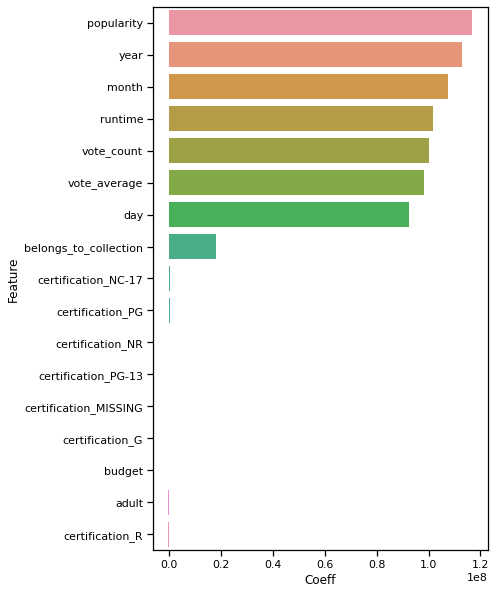

In [96]:
## Visualize Coefficients
sns.set_context('notebook')
plot_coeffs = pd.DataFrame({'Feature':result.params.index,
                          'Coeff':result.params})
plot_coeffs.drop('const',inplace=True)
plt.figure(figsize=(6,10))
sns.barplot(data=plot_coeffs.sort_values('Coeff',ascending=False), y="Feature", x="Coeff")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
# ax = result.params.sort_values().plot(kind='barh',figsize=(6,12))
ax.axhline(color='black');
# ax.set_title

# Compare to Alternative Regressors

## Random Forest

In [97]:
from sklearn.ensemble import RandomForestRegressor
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)

reg = RandomForestRegressor(verbose=1,random_state=42)
reg.fit(X_train_df, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


RandomForestRegressor(random_state=42, verbose=1)

In [98]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = reg.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = reg.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.970
Testing R^2: 0.797


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


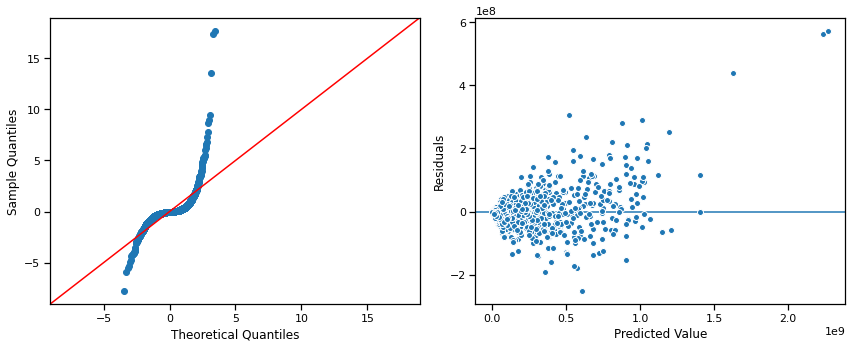

In [99]:
pf.evaluate_ols(reg, X_train_df, y_train)

### Built-In Importances

- Figure saved as Images/rf_importance.png


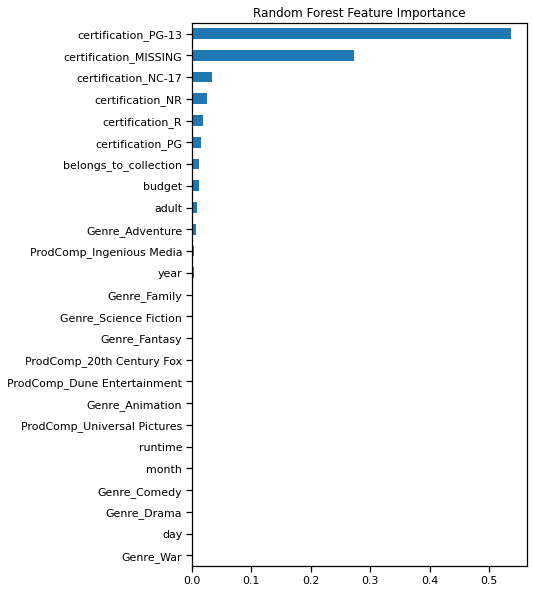

In [100]:
importances = pd.Series(reg.feature_importances_, index=X_train_df.columns)
ax = importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))
ax.set_title('Random Forest Feature Importance')
pf.savefig('Images/rf_importance.png',ax=ax)

### Permutation Importance

> Permutation Importances will iteratively shuffle the rows of a single feature at a time to asses the model's change in performance with that feature's relationship with the target disrupted. 
- https://scikit-learn.org/stable/modules/permutation_importance.html

```python
from sklearn.inspection import permutation_importance
r = permutation_importance(svc_linear, X_test_df, y_test, n_repeats=30)
r.keys()
```
- Interesting Observation: 
    - permutation_importance takes a `scoring` argument!

> "**Warning Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model.** Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model."

In [101]:
from sklearn.inspection import permutation_importance

In [102]:
## Permutation importance takes a fit mode and test data. 
r = permutation_importance(reg, X_test_df, y_test,
                           n_repeats=30)
r.keys()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


dict_keys(['importances_mean', 'importances_std', 'importances'])

In [103]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_df.columns,
                           name = 'permutation importance')
permutation_importances

certification_G                       0.000000
certification_MISSING                 0.401681
certification_NC-17                   0.014307
certification_NR                      0.005802
certification_PG                      0.008168
                                        ...   
ProdComp_Village Roadshow Pictures    0.000430
ProdComp_Walt Disney Pictures        -0.000571
ProdComp_Warner Bros. Pictures        0.000117
ProdComp_Working Title Films          0.000035
const                                 0.000000
Name: permutation importance, Length: 87, dtype: float64

- Figure saved as Images/permutation_importance.png


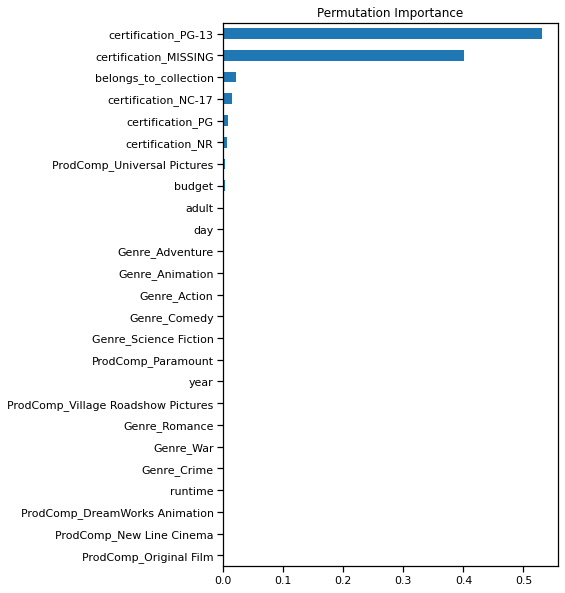

In [104]:
ax = permutation_importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))
ax.set_title('Permutation Importance')
pf.savefig('Images/permutation_importance.png',ax=ax)

## Using SHAP and Shapely Values for Model Interpretation

>- SHAP (SHapley Additive exPlanations)) 
    - [Repository](https://github.com/slundberg/shap)
    - [Documentation](https://shap.readthedocs.io/en/latest/?badge=latest)
        - Install via pip or conda.
  

- SHAP uses game theory to calcualte Shapely values for each feature in the dataset. 
- Shapely values are calculated by iteratively testing each feature's contribution to the model by comparing the model's  performance with vs. without the feature. (The "marginal contribution" of the feature to the model's performance).



#### Papers, Book Excerpts, and  Blogs
- [White Paper on Shapely Values](https://arxiv.org/abs/1705.07874)
    
- [Intepretable Machine Learning Book - Section on SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)
    
- Towards Data Science Blog Posts:
    - [Explain Your Model with SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

    - [Explain Any Model with SHAP KernelExplaibner](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)





#### Videos/Talks:
- Explaining Machine Learning Models (in general).
    - ["Open the Black Box: an intro to Model Interpretability with LIME and SHAP](https://youtu.be/C80SQe16Rao)
- Understanding Shapely/SHAP Values:
    - [AI Simplified: SHAP Values in Machine Learning ](https://youtu.be/Tg8aPwPPJ9c)- (Intuitive Explanation)
    - [Explainable AI explained! | #4 SHAP  ](https://youtu.be/9haIOplEIGM)- (Math Calculation Explanation)


### How to Use Shap

- Uses game theory to explain feature importance and how a feature steered a model's prediction(s) by removing each feature and seeing the effect on the error.

- SHAP has:
    - `TreeExplainer`:
        - compatible with sckit learn, xgboost, Catboost
    - `KernelExplainer`:
        - compatible with "any" model
        


- See [this blog post](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) for intro to topic and how to use with trees

- For non-tree/random forest models [see this follow up post]( https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

        

### Using Shap for Regression Models
- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [105]:
import shap 
print(shap.__version__)
shap.initjs()

0.40.0


In [106]:
# ## Initialize an explainer with the model
# explainer = shap.TreeExplainer(reg)

# ## Calculaate shap values for test data
# shap_values = explainer.shap_values(X_test_df,y_test)
# len(shap_values)

In [ ]:
# !pip install interpret


In [108]:
X100 = shap.utils.sample(X_train_df, 100) 
X100

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Comedy,Genre_Music,Genre_Romance,Genre_Science Fiction,Genre_Drama,Genre_Action,Genre_Crime,Genre_Adventure,Genre_Animation,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films,const
31025,0.0,30000000.0,18.994,85.0,6.8,1089.0,2014.0,11.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36757,0.0,60000000.0,64.444,102.0,7.7,3038.0,2016.0,8.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6636,0.0,25000000.0,10.620,99.0,4.2,398.0,2005.0,10.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9941,0.0,300000000.0,492.559,169.0,7.2,12000.0,2007.0,5.0,19.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8322,0.0,1100000.0,1.424,105.0,4.1,7.0,2006.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [109]:
# Adapted from: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X_train_df, y_train)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X_train_df)

OSError: dlopen(/Users/codingdojo/.local/lib/python3.8/site-packages/interpret/glassbox/ebm/../../lib/lib_ebm_native_mac_x64.dylib, 0x0006): tried: '/Users/codingdojo/.local/lib/python3.8/site-packages/interpret/glassbox/ebm/../../lib/lib_ebm_native_mac_x64.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e')), '/Users/codingdojo/.local/lib/python3.8/site-packages/interpret/lib/lib_ebm_native_mac_x64.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))

In [ ]:

sample_ind = np.random.choice(range(len(X_test_df)))
print(sample_ind)
X_test_df.iloc[sample_ind].to_frame().T

In [ ]:
shap_values[sample_ind]

In [ ]:
shap.plots.waterfall(shap_values[sample_ind])#, max_display=14)
